Description:  This script produces Figure 7 (equivalent reflectivity factor contours for Edmond-Carney storm at surface and mid-levels) and

Figure 8 (azimuthal shear at mid-levels + time series of maximum azimuthal shear within 0-3 km, 3-6 km, and 6-9 km layers)

In [6]:
import glob
import os
import sys
from copy import deepcopy
from datetime import datetime
from operator import itemgetter

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyart
import scipy.ndimage as ndimage
import xarray as xr
from matplotlib.pyplot import cm
import matplotlib.dates as mdates



from may19_2013_obs_analysis.wsr88d_parsing import plot_point
from may19_2013_obs_analysis.utils import ray_height

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["font.size"] = 13

In [3]:
# list out all level-II radar files (20:02:36 UTC to 22:57:25 UTC)
files_radar = sorted(glob.glob(os.path.expanduser("path/to/KTLX_data/*V06")))

# list out all azimuthal shear files (20:02:36 UTC to 22:57:25 UTC)
files_az_shear = sorted(glob.glob(os.path.expanduser("path/to/azimuthal_shear_files/*.nc")))

# select only the ones needed for Figure 7
files_rad_interest = list(
    itemgetter(6, 7, 8, 9, 10, 11, 17, 18, 19, 26, 27, 30)(files_radar)
)

files_az_shear_interest = list(
    itemgetter(6, 7, 8, 9, 10, 11, 17, 18, 19, 26, 27, 30)(files_az_shear)
)

In [4]:
# List of all elevation angles (sweep angles) that have a visible WER/BWER in PPI plot
# This list will be used while iterating through radar files

mdlvl_swps = [11, 11, 12, 12, 12, 13, 12, 12, 12, 10, 10, 10]
mdlvl_swps = np.reshape(mdlvl_swps, (4, 3))

In [5]:
# despeckle radar reflectivity field and mask reflectivity values lower than 20 dBZ

all_radars = []

for i in range(len(files_rad_interest)):

    radar = pyart.io.read(files_rad_interest[i])
    filter = pyart.filters.GateFilter(radar)
    filter.exclude_below("reflectivity", 20)
    filter = pyart.correct.despeckle_field(
        radar, "reflectivity", size=30, gatefilter=filter
    )
    corrected_reflectivity = deepcopy(radar.fields["reflectivity"])
    corrected_reflectivity["data"] = np.ma.masked_where(
        filter.gate_excluded, corrected_reflectivity["data"]
    )
    radar.add_field(
        "corrected_reflectivity", corrected_reflectivity, replace_existing=True
    )

    all_radars.append(radar)

In [7]:
# manually identified xy locs of approximate BWER location visible in reflectivity plots above 

x_pts = [-45,-45,-40,-35,-35,-35,-15,-10,-10,15,15,20]*np.array([1000])
y_pts = [30,30,35,35,40,35,35,40,40,45,50,60]*np.array([1000])

f = lambda x,y: np.sqrt(x**2 + y**2)

ranges = list(map(f,x_pts,y_pts))

bm_hghts = [ray_height(r,all_radars[i].fixed_angle['data'][el],15) for i,r,el in zip(np.arange(len(all_radars)),ranges, mdlvl_swps.reshape(12,1))]

PPI plots for equivalent reflectivity factor

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


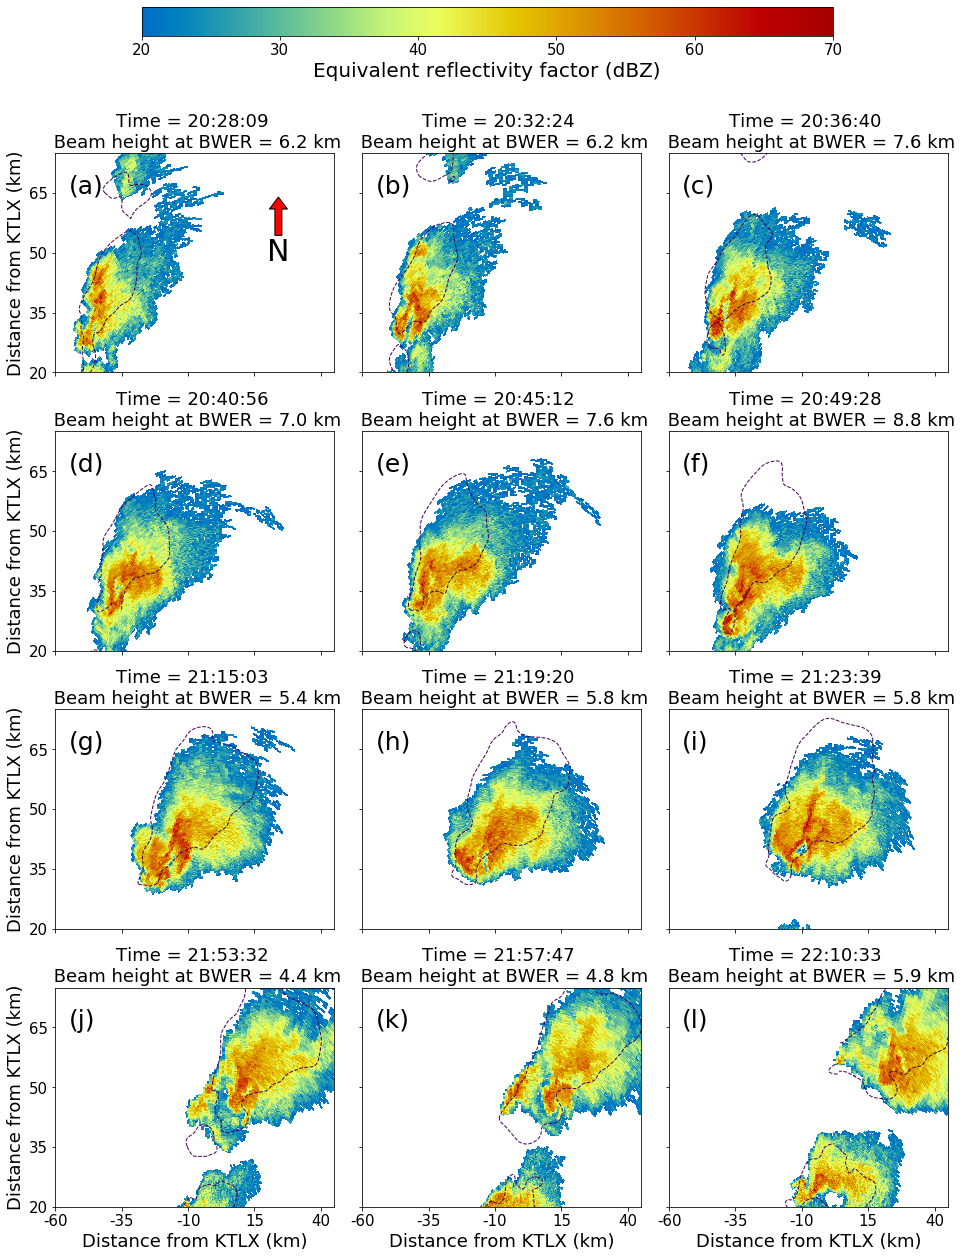

In [8]:
# panel plot for radar reflectivity at mid-levels (shaded) and low-level reflectivity (30 dBZ contour)

all_radars_new = np.reshape(all_radars, (4, 3))
llvl_swp = 0
widths = [15, 15, 15]
heights = [10, 10, 10, 10]

fig = plt.figure(constrained_layout=False, figsize=(16, 20))
spec2 = gridspec.GridSpec(
    ncols=3, nrows=4, figure=fig, width_ratios=widths, height_ratios=heights
)
spec2.update(wspace=0.1, hspace=0.1)
labels = list(map(chr, range(97, 109)))

labels1 = np.array(labels).reshape(4,3)

for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(spec2[row, col])
        display = pyart.graph.RadarDisplay(all_radars_new[row, col])
        p = display.plot_ppi(
                            "corrected_reflectivity",
                            mdlvl_swps[row, col],
                            vmin=20,
                            vmax=70,
                            cmap="pyart_HomeyerRainbow",
                            title_flag=False,
                            colorbar_flag=False,
                            colorbar_orient="horizontal",
                            axislabels_flag=False,
                            ax = ax,
                            fig = fig
                        )

        llvl_data = all_radars_new[row, col].get_field(
            llvl_swp, "corrected_reflectivity"
        )
        x, y, z = all_radars_new[row, col].get_gate_x_y_z(llvl_swp, edges=False)

        x /= 1000.0
        y /= 1000.0
        z /= 1000.0

        # apply a gaussian blur to the data set for nice smooth lines:
        # sigma adjusts the distance effect of blending each cell,
        # 4 is arbirarly set for visual impact.
        smooth_data = ndimage.gaussian_filter(llvl_data, sigma=4)

        # add contours
        levels = [30]

        # adds contours to plot
        contours = ax.contour(
            x, y, smooth_data, levels, linewidths=1, antialiased=True, linestyles="--"
        )

        ratio = 1.5
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        # the abs method is used to make sure that all numbers are positive
        # because x and y axis of an axes maybe inversed.
        ax.set_aspect(abs((xright - xleft) / (ybottom - ytop)) * ratio)

        ax.set_xlim(-60, 45)
        ax.set_xticks([-60, -35, -10, 15, 40])
        ax.set_xticklabels(["-60", "-35", "-10", "15", "40"])

        ax.set_ylim(20, 75)
        ax.set_yticks([20, 35, 50, 65])
        ax.set_yticklabels(["20", "35", "50", "65"])
        ax.text(-55,65, f"({labels1[row,col]})",fontsize=25)
        
        if col in [1,2] and row in [0,1,2]:
            ax.set_xticklabels(labels=[])
            ax.set_yticklabels(labels=[])
            
        if row in [0,1,2]:
            ax.set_xticklabels(labels=[])
#             ax.set_yticklabels(labels=[])
        
        if col in [1,2]:
            ax.set_yticklabels(labels=[])

        title = datetime.strftime(
            datetime.strptime(
                all_radars_new[row, col]
                .time["units"]
                .split("/")[-1]
                .split(".")[0]
                .split(" ")[-1],
                "%Y-%m-%dT%H:%M:%SZ",
            ),
            "%H:%M:%S",
        )
#         ax.set_title(f"Time = {title}",fontsize=18)
        ax.set_title(f"Time = {title} \n Beam height at BWER = {round(int(np.reshape(bm_hghts,(4,3))[row,col])/1000,1)} km",fontsize=18)

        if col == 0:
            ax.set_ylabel("Distance from KTLX (km)",fontsize=18)
            if row == 0:
                ax.annotate('N', xy=(0.8, 0.8), xytext=(0.8, 0.55),
                                        arrowprops=dict(facecolor='red', width=7, headwidth=18),
                                        ha='center', va='center', fontsize=30,
                                        xycoords=ax.transAxes)
            
        if row == 3:
            ax.set_xlabel("Distance from KTLX (km)",fontsize=18)

cbaxes = fig.add_axes([0.2,0.95,0.6,0.02])
display.plot_colorbar(cax=cbaxes,orient='horizontal')

cbaxes.axes.set_xlabel('Equivalent reflectivity factor (dBZ)',fontsize=20)

plt.tight_layout()
plt.show()


PPI plots for azimuthal shear

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/pyart/io/cfradial.py:365: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/pyart/io/cfradial.py:365: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


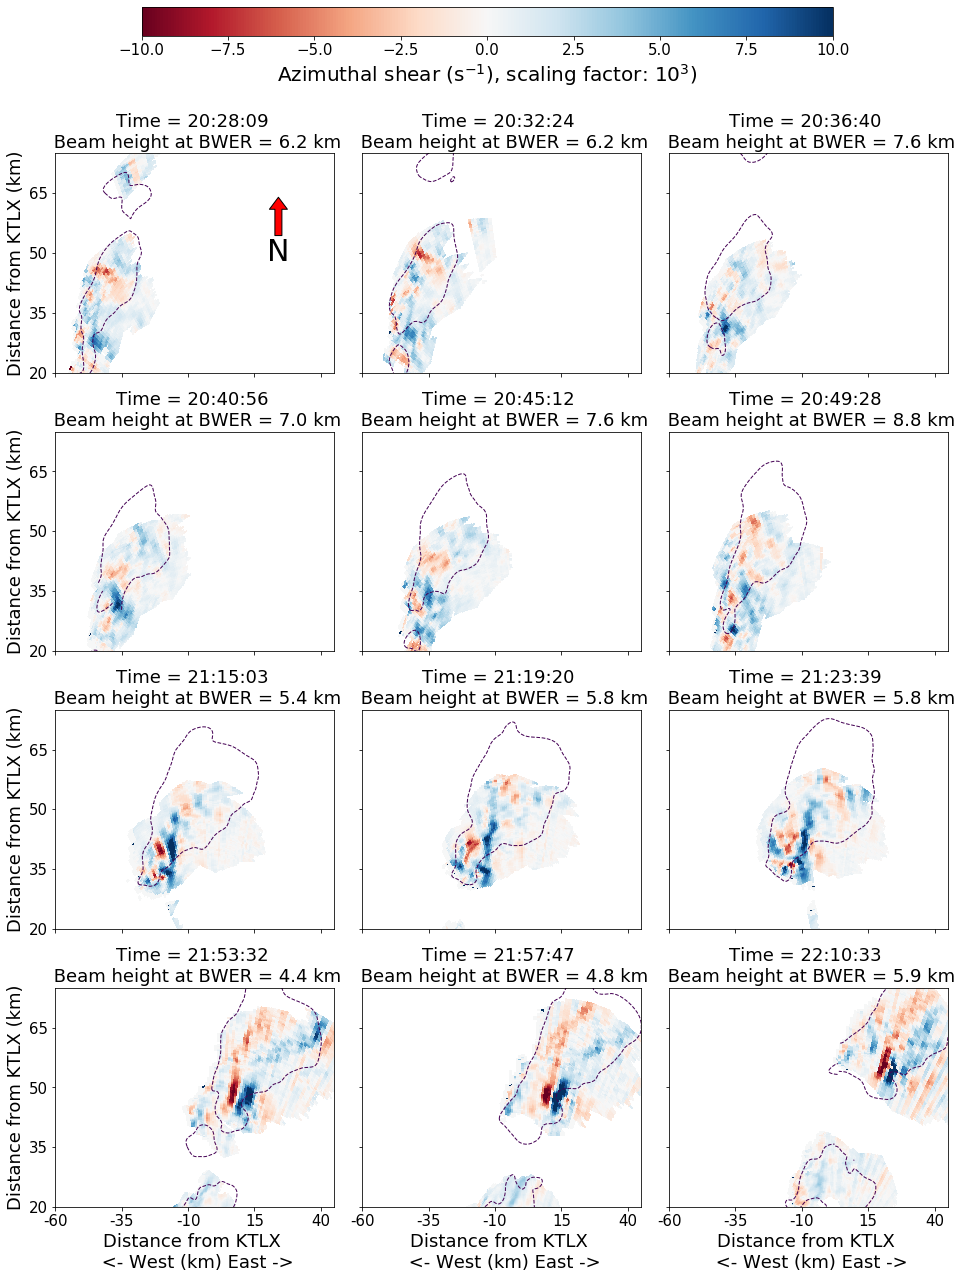

In [9]:
all_azshear_radars = []

for i in range(len(files_az_shear_interest)):
    radar = pyart.io.read(files_az_shear_interest[i])
    all_azshear_radars.append(radar)
    
# panel plot for azimuthal shear at mid-levels (shaded) and low-level reflectivity (30 dBZ contour)

all_radars_new = np.reshape(all_azshear_radars, (4, 3))
all_refl_radars_new = np.reshape(all_radars, (4, 3))

llvl_swp = 0
widths = [15, 15, 15]
heights = [10, 10, 10, 10]

fig = plt.figure(constrained_layout=False, figsize=(16, 20))
spec2 = gridspec.GridSpec(
    ncols=3, nrows=4, figure=fig, width_ratios=widths, height_ratios=heights
)
spec2.update(wspace=0.1, hspace=0.1)
labels = list(map(chr, range(97, 109)))

labels1 = np.array(labels).reshape(4,3)

for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(spec2[row, col])
        display = pyart.graph.RadarDisplay(all_radars_new[row, col])
        p = display.plot_ppi(
                            "azi_shear",
                            mdlvl_swps[row, col],
                            vmin=-10,
                            vmax=10,
                            cmap=cm.RdBu,
                            title_flag=False,
                            colorbar_flag=False,
                            colorbar_orient="horizontal",
                            axislabels_flag=False,
                            ax = ax,
                            fig = fig
                        )
        
        llvl_data = all_refl_radars_new[row, col].get_field(
            llvl_swp, "corrected_reflectivity"
        )
        x, y, z = all_refl_radars_new[row, col].get_gate_x_y_z(llvl_swp, edges=False)

        x /= 1000.0
        y /= 1000.0
        z /= 1000.0

        # apply a gaussian blur to the data set for nice smooth lines:
        # sigma adjusts the distance effect of blending each cell,
        # 4 is arbirarly set for visual impact.
        smooth_data = ndimage.gaussian_filter(llvl_data, sigma=4)

        # add contours
        levels = [30]

        # adds contours to plot
        contours = ax.contour(
            x, y, smooth_data, levels, linewidths=1, antialiased=True, linestyles="--"
        )
        
        ratio = 1.5
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        # the abs method is used to make sure that all numbers are positive
        # because x and y axis of an axes maybe inversed.
        ax.set_aspect(abs((xright - xleft) / (ybottom - ytop)) * ratio)

        ax.set_xlim(-60, 45)
        ax.set_xticks([-60, -35, -10, 15, 40])
        ax.set_xticklabels(["-60", "-35", "-10", "15", "40"])

        ax.set_ylim(20, 75)
        ax.set_yticks([20, 35, 50, 65])
        ax.set_yticklabels(["20", "35", "50", "65"])
#         ax.text(-55,65, f"({labels1[row,col]})",fontsize=25)
        
        if col in [1,2] and row in [0,1,2]:
            ax.set_xticklabels(labels=[])
            ax.set_yticklabels(labels=[])
            
        if row in [0,1,2]:
            ax.set_xticklabels(labels=[])
        
        if col in [1,2]:
            ax.set_yticklabels(labels=[])

        title = datetime.strftime(
            datetime.strptime(
                all_radars_new[row, col]
                .time["units"]
                .split("/")[-1]
                .split(".")[0]
                .split(" ")[-1],
                "%Y-%m-%dT%H:%M:%SZ",
            ),
            "%H:%M:%S",
        )
        ax.set_title(f"Time = {title} \n Beam height at BWER = {round(int(np.reshape(bm_hghts,(4,3))[row,col])/1000,1)} km",fontsize=18)

        if col == 0:
            ax.set_ylabel("Distance from KTLX (km)",fontsize=18)
            if row == 0:
                ax.annotate('N', xy=(0.8, 0.8), xytext=(0.8, 0.55),
                                        arrowprops=dict(facecolor='red', width=7, headwidth=18),
                                        ha='center', va='center', fontsize=30,
                                        xycoords=ax.transAxes)
        if row == 3:
            ax.set_xlabel("Distance from KTLX \n <- West (km) East ->",fontsize=18)

cbaxes = fig.add_axes([0.2,0.95,0.6,0.02])
display.plot_colorbar(cax=cbaxes,orient='horizontal')

cbaxes.axes.set_xlabel('Azimuthal shear (s$^{-1}$), scaling factor: 10$^{3}$)',fontsize=20)

plt.tight_layout()
plt.show()

#### Plot time series of azimuthal shear limited to EC storm within our grid domain

In [10]:
import xarray as xr
from matplotlib import dates
from may19_2013_obs_analysis.wsr88d_parsing import extent_pid as extent_storm
from may19_2013_obs_analysis.utils import npdt_to_datetime

In [11]:
# Load data from lasso analysis generated flash stats csv file using lmatools
lasso = '../data/interim/flash_stats.csv'

lasso_data = pd.read_csv(lasso, usecols=[0, 2])
lasso_data = lasso_data[0:-1]
lasso_data.columns = ['time', 'number']

lasso_data.index = pd.to_datetime(lasso_data['time'])
lasso_data = lasso_data.drop(columns=['time'])
lasso_data = lasso_data.rename({'number':'total flash rate'},axis=1)

In [12]:
# using gridded azimuthal shear field (Gridding performed using RadX2Grid)
# grid shape and extent is the same as grid used for polarimetric variables

az_files = sorted(glob.glob('path/to/gridded/azimuthal_shear/*.nc'))

In [13]:
# load all gridded files at once
data = xr.open_mfdataset(az_files)

In [14]:
az_shear_data = data['azi_shear']
az_shear_data = az_shear_data.assign_coords({'time':data['start_time'].compute()})

In [22]:
# apply domain extent limits for each time to restrict analysis to Edmond-Carney storm 

ec_azi_shear_only = []
for i in range(39): # 39 bcoz after 2249 UTC, EC storm exits our gridded domain 
    ll_lon, ul_lon, ll_lat, ul_lat = extent_storm(
        npdt_to_datetime(az_shear_data.time[i])
    )
    tmp = (
        az_shear_data
        .isel(time=i)
        .where(
            (az_shear_data.lon0 >= ll_lon)
            & (az_shear_data.lon0 <= ul_lon)
            & (az_shear_data.lat0 >= ll_lat)
            & (az_shear_data.lat0 <= ul_lat),
            drop=True,
        )
    )
    
    ec_azi_shear_only.append(tmp)

In [16]:
# concatenate azimuthal shear values for all the times
final_ec_azi_shear = xr.concat(ec_azi_shear_only,dim='time')

In [18]:
def gaussian_1sigma(ds):
    import scipy
    s = []
    for i in range(len(ds.time)):
        u = scipy.ndimage.gaussian_filter(ds.isel(time=i).max(dim=['z0']),1)*10**-3
        s.append(np.nanmax(u))
    return s

Apply Gaussian filtering on azimuthal shear values to remove noise

In [ ]:
mas_03 = gaussian_1sigma(final_ec_azi_shear.sel(z0 = slice(0,3)))
mas_36 = gaussian_1sigma(final_ec_azi_shear.sel(z0 = slice(3,6)))
mas_69 = gaussian_1sigma(final_ec_azi_shear.sel(z0 = slice(6,9)))

df_mas03 = pd.DataFrame(mas_03,index=final_ec_azi_shear.time.data,columns=['0-3 km'])
df_mas36 = pd.DataFrame(mas_36,index=final_ec_azi_shear.time.data,columns=['3-6 km'])
df_mas69 = pd.DataFrame(mas_69,index=final_ec_azi_shear.time.data,columns=['6-9 km'])

In [23]:
# Functions to apply a maximum azimuthal shear jump algorithm (analogous to lightning jump algorithm)
# Similar to Stough et al. (2017)

def check_masja_valid(dtidx,mas,df):
    
    from datetime import timedelta
    """
    This function applies an analogous form of lightning jump
    algorithm (Schultz et al. 2011) to maximum azimuthal shear. 
    We ignore the second of two consecutive jumps, if they occur.
    
    Input:
    ------
    dtidx : Datetime Index corresponding to initally identified LJs
    
    Returns:
    ------
    valid lightning jump datetime indices from current time
    """
    df1 = df.copy()
    # define a threshold of 1 * 10**-2 s-1 for algorithm to trigger a jump in mas
    masja_idx = mas.loc[dtidx[dtidx].index] > 1 * 10**-2
    df1.loc[masja_idx.index[masja_idx[mas.columns[0]]].tolist(), 'MASJA cls'] = 'Y'
    
    return df1

def masja_algo(df_mas):
    """
    applies a two-sigma threshold (analogous to LJA)
    to maximum azimuthal shear derived from radar data
    using PyMeso.
    
    Input:
    -----
    
    Returns:
    -----
    
    """
    # create a pandas dataframe to calculate ~16-20 min avg
    # max azimuthal shear (mas)
    df_time = pd.DataFrame(df_mas.index,columns=[df_mas.columns[0]])
    radar_tintv = df_time.diff().astype('timedelta64[m]') #convert time diff to approx minutes
    radar_tintv.index = df_mas.index
    
    a = df_mas.diff()/radar_tintv # divide differential mas with time interval to get average value
    
    # apply a rolling window to calculate mas standard deviation for previous three radar volumes
    b = a.rolling(window=3,).apply(lambda x: np.nanstd(x))
    b = b.shift(periods=1)
    two_sigma = 2*b # define two sigma threshold
    
    masja = (a >= two_sigma) #mas jump is counted when average mas value exceeds 2sigma threshold
    
    a['MASJA cls'] = 'N' # assign a 'No jump value' to all times initially 
    
    # check if masja identified above passes the minimum mas value threshold
    tt = check_masja_valid(masja[df_mas.columns[0]],df_mas,a)
    
    return tt,two_sigma

In [24]:
# Let's apply the masja algorithm to all the layers
tt03,two_sigma03 = masja_algo(df_mas03) # 0-3 km layer
tt36,two_sigma36 = masja_algo(df_mas36) # 3-6 km layer
tt69,two_sigma69 = masja_algo(df_mas69) # 6-9 km layer

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


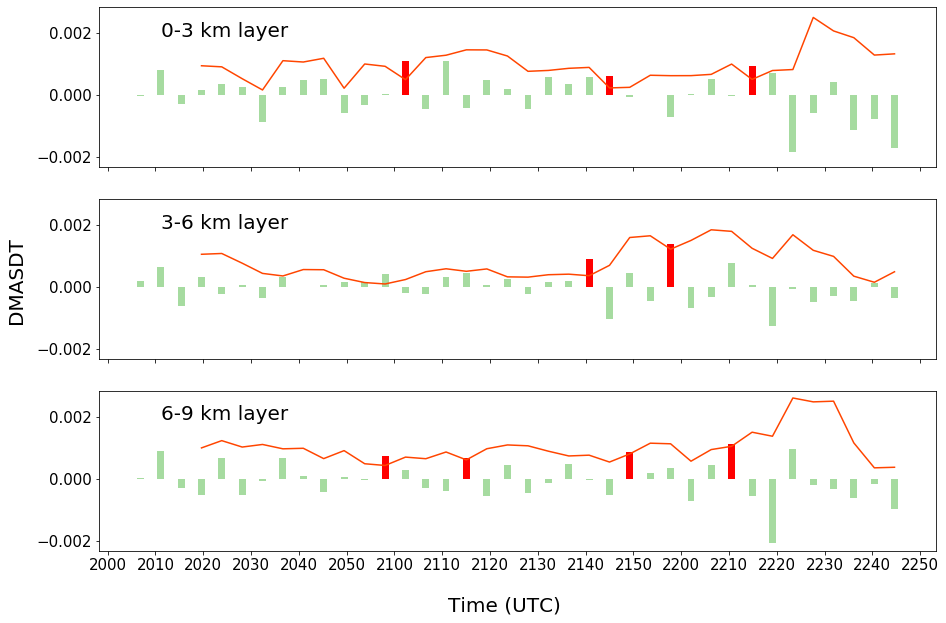

In [25]:
colors = {'N': '#a6dba0', 'Y': 'r'}

# Create figure and plot space
fig, ax = plt.subplots(3,1,figsize=(15, 10),sharex=True, sharey=True,)

#--------------- 0-3 km layer
color_list = [colors[i] for i in tt03['MASJA cls']]
ax[0].bar(tt03.index.values,
       tt03['0-3 km'],
       width=0.001,
       color=color_list)

ax[0].plot(two_sigma03,color='orangered')
ax[0].annotate('0-3 km layer', xy=(0.8, 0.8), xytext=(0.15, 0.85),
                ha='center', va='center', fontsize=20,
                xycoords=ax[0].transAxes)

#--------------- 3-6 km layer
color_list = [colors[i] for i in tt36['MASJA cls']]
ax[1].bar(tt36.index.values,
       tt36['3-6 km'],
       width=0.001,
       color=color_list)

ax[1].plot(two_sigma36,color='orangered')
ax[1].annotate('3-6 km layer', xy=(0.8, 0.8), xytext=(0.15, 0.85),
                ha='center', va='center', fontsize=20,
                xycoords=ax[1].transAxes)

#--------------- 6-9 km layer
color_list = [colors[i] for i in tt69['MASJA cls']]
ax[2].bar(tt69.index.values,
       tt69['6-9 km'],
       width=0.001,
       color=color_list)

ax[2].plot(two_sigma69,color='orangered')
ax[2].annotate('6-9 km layer', xy=(0.8, 0.8), xytext=(0.15, 0.85),
                ha='center', va='center', fontsize=20,
                xycoords=ax[2].transAxes)

# Define the date format
ax[2].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax[2].tick_params(axis='x',labelrotation=0)

fig.text(0.5, 0.04, "Time (UTC)", ha='center',fontsize=20)
fig.text(0.04, 0.5, 'DMASDT', va='center', rotation='vertical',fontsize=20)


plt.show()

In [26]:
def my_annotate(
    ax, s, xy_arr=[], *args, **kwargs
):  # code taken from https://stackoverflow.com/a/14545981/12538451
    ans = []
    an = ax.annotate(s, xy_arr[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d["xycoords"] = kwargs["xycoords"]
    except KeyError:
        pass
    try:
        d["arrowprops"] = kwargs["arrowprops"]
    except KeyError:
        pass
    for xy in xy_arr[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0, 0), textcoords=an, **d)
        ans.append(an)
    return ans

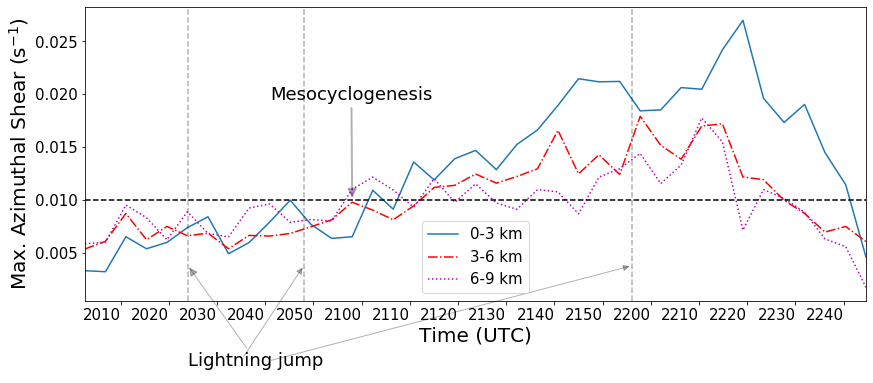

In [27]:
fig,ax = plt.subplots(figsize=(14,6))
df_mas03.plot(ax=ax,label='0-3 km',linestyle='-')
df_mas36.plot(c='r',ax=ax,label='3-6 km',linestyle='-.')
df_mas69.plot(c='m',ax=ax,label='6-9 km',linestyle=':')
ax.axhline(y=1.0*10**-2,linestyle='--',c='k')
ax.legend(loc='best')

ax.set_xlabel('Time (UTC)',fontsize=20)
ax.set_ylabel('Max. Azimuthal Shear (s$^{-1}$)',fontsize=20)

ax.axvline(x = datetime(2013,5,19,20,24,0),c='k',linestyle='--',alpha=0.3)
ax.axvline(x = datetime(2013,5,19,20,48,0),c='k',linestyle='--',alpha=0.3)
ax.axvline(x = datetime(2013,5,19,21,56,0),c='k',linestyle='--',alpha=0.3)

# plotting the mesocyclogenesis time
my_annotate(
    ax,
    "Mesocyclogenesis",
    xy_arr=[
        (df_mas03[(df_mas69['6-9 km'] > 0.01)].first_valid_index(), 0.010),
    ],
    xycoords="data",
    xytext=(-82, 100),
    textcoords="offset points",
#     bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="#c203fc",alpha=0.3,lw=2),
    fontsize=18,
)

my_annotate(
    ax,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 20, 24, 0), 0.0038),
        (datetime(2013, 5, 19, 20, 48, 0), 0.0038),
        (datetime(2013, 5, 19, 21, 56, 0), 0.0038),
    ],
    xycoords="data",
    xytext=(0, -100),
    textcoords="offset points",
#     bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=18,
)

ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax.tick_params(axis='x',labelrotation=0)

# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/mesocyclone.png',
#            dpi=300, bbox_inches='tight')
plt.show()

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/xarray/plot/plot.py:943: UserWarning: The following kwargs were not used by contour: 'labelpad'
  primitive = ax.contourf(x, y, z, **kwargs)


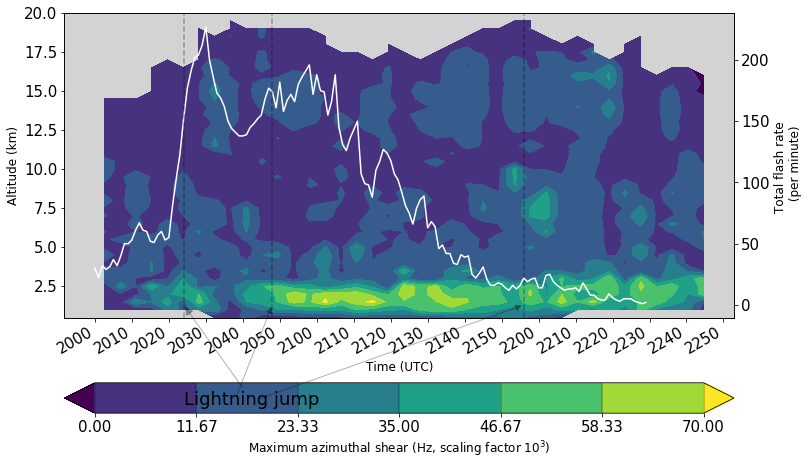

In [61]:
final_ec_azi_shear = xr.concat(ec_azi_shear_only,dim='time')

g = final_ec_azi_shear.max(dim=['x0','y0']).T.plot.contourf(labelpad=5,
                                                           vmin = 0,
                                                           vmax = 70,
                                                           robust=True,
                                                          cbar_kwargs = dict(# xticks = np.arange(1,18,1),
                                                                                      orientation="horizontal",
                                                                                      pad=0.15,
                                                                                      shrink=1,
                                                                                      label="Maximum azimuthal shear (Hz, scaling factor 10$^{3}$)",
#                                                                                       ticks=ticker.ticks,
                                                                                      drawedges=True,
                                                                                    ),
                                                          )


g.ax.xaxis.set_major_formatter(dates.DateFormatter("%H%M"))
g.ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
g.ax.set_xlabel('Time (UTC)')
g.ax.set_ylabel('Altitude (km)')
g.ax.set_facecolor('lightgray')

ax2 = g.ax.twinx()

with pd.plotting.plot_params.use('x_compat', True):
    fr = ax2.plot(lasso_data,label='Total flash rate',c='w')

ax2.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%H%M'))
ax2.set_ylabel('Total flash rate \n (per minute)')

my_annotate(
    ax2,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 20, 24, 0), 0.0038),
        (datetime(2013, 5, 19, 20, 48, 0), 0.0038),
        (datetime(2013, 5, 19, 21, 56, 0), 0.0038),
    ],
    xycoords="data",
    xytext=(0, -100),
    textcoords="offset points",
#     bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=18,
)

ax2.axvline(x = datetime(2013,5,19,20,24,0),c='k',linestyle='--',alpha=0.3)
ax2.axvline(x = datetime(2013,5,19,20,48,0),c='k',linestyle='--',alpha=0.3)
ax2.axvline(x = datetime(2013,5,19,21,56,0),c='k',linestyle='--',alpha=0.3)


/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


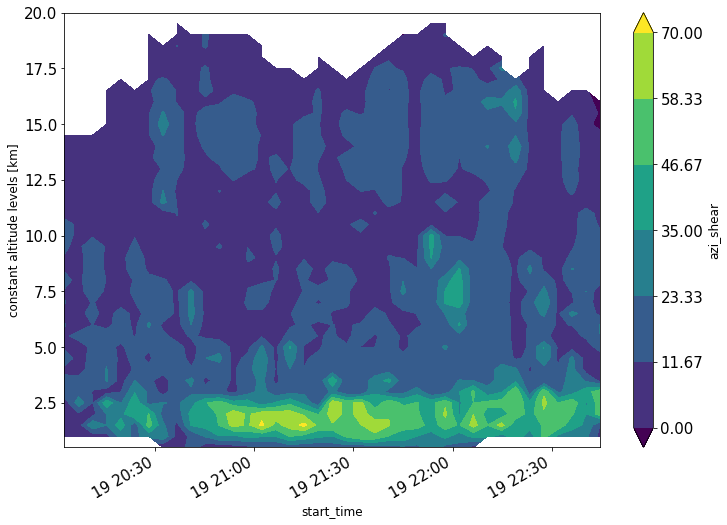

In [46]:
final_ec_azi_shear.chunk({'time':1,'z0':1}).max(dim=['x0','y0']).T.plot.contourf(cmap='viridis',vmin=0,vmax=70)

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


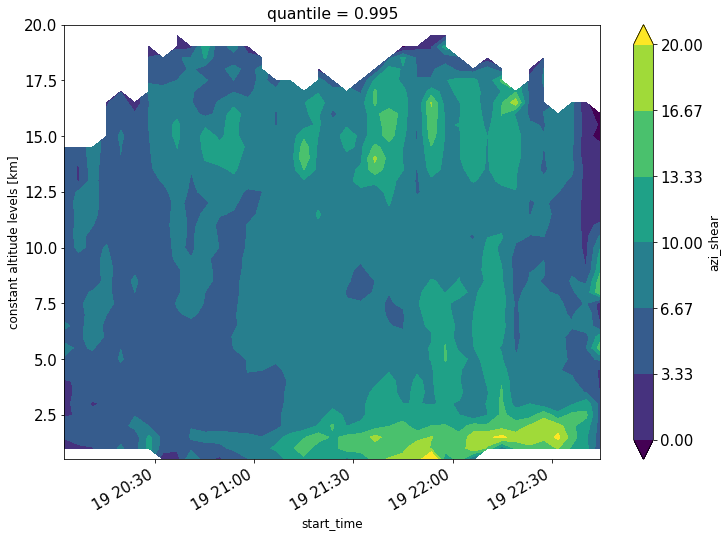

In [55]:
final_ec_azi_shear.chunk({'time':1,'z0':1}).quantile(0.995,dim=['x0','y0']).T.plot.contourf(cmap='viridis',vmin=0,vmax=20)

In [ ]:
final_ec_azi_shear.chunk({'time':1}).quantile(0.995,dim=['z0']).plot.pcolormesh(col='time',col_wrap=3,vmin=0,vmax=20)